# Helper Functions Volume 4: Feature Engineering & Model preparation

Author: Koh Kok Bin  
Date: 17 Feb 2022

This notebook provides some basic walkthroughs on how best to optimize features (aka parameters or x 'predictor' variables). It is not meant to be exhaustive but should cover most of what is done during data science projects.

### <a id = "VOL4_toc"> Table of contents:  </a>
- [Reference Materials -- This needs to be run so that Parts 1 to n can work.](#VOL4_refmat)  
- [Feature selection -- Which variable is redundant & How to transform variables for best results](#VOL4_feat_select)  
    - [Month, Town](#VOL4_mth)  
    - [Flat type](#VOL4_flat)  
    - [Block, Street name](#VOL4_blk)  
    - [Storey range](#VOL4_storey)  
    - [Floor area sqm, flat model](#VOL4_sqm)  
    - [Lease commence date](#VOL4_lease)
- [Model prep, Dataset split](#VOL4_modelprep)  
    - [Sampling](#VOL4_sampling)
    - [Testing for Significance](#VOL4_signif)  
    - [Evaluation](#VOL4_eval)


The generic idea is tho perform feature engineering to ensure table is rid of unnecessary data, and is in a format that can be easily interpreted (accurately) by the model itself. Only when that is done, the pre-model preparation like train/test split etc should be performed. 

### <a id = "VOL4_refmat"> Reference Materials </a>  

In [2]:
import os
import pandas as pd
import numpy as np

%matplotlib inline

In [3]:
# Get directory name of this file. Helpful to specify the directory of the file, 
# so you can also interact with the files in the same location via relative paths.

dirname = globals()["_dh"][0]

In [4]:
data_folder = "VOL4"
list_of_files = os.listdir(os.path.join(dirname, data_folder)) # Absolute path
list_of_files2 = os.listdir(data_folder) # Relative path

# They are the same; only 1 file in folder
list_of_files == list_of_files2

True

In [5]:
# Replace function is meant to ensure sharepoint files will work.
# This code is more readable too.
datafile = os.path.join(dirname, data_folder, list_of_files[0]).replace("\\", "/")
df = pd.read_csv(datafile)

In [6]:
df2 = df.copy()

In [7]:
df2.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0


In [8]:
# Conduct preliminary processing, aka the usual ones done in the earlier helper volumes
df2.columns = map(str.upper, df2.columns)

In [9]:
df2.columns

Index(['MONTH', 'TOWN', 'FLAT_TYPE', 'BLOCK', 'STREET_NAME', 'STOREY_RANGE',
       'FLOOR_AREA_SQM', 'FLAT_MODEL', 'LEASE_COMMENCE_DATE',
       'REMAINING_LEASE', 'RESALE_PRICE'],
      dtype='object')

### <a id = "VOL4_feat_select"> Feature Selection / Engineering </a>   

[Return to top](#VOL4_toc)

This step is not heavily discussed, but makes sense. In machine learning and in life, we deal with noise all the time. Only a few signals matter and its important to tune out the noise. For datasets that have many columns, choosing the relevant ones to build the model will improve your model by a great extent. Your model will assume all features being provided *are* important.

We know that from experience (or domain knowledge), only a few things matter to prices of resale transactions. For example, the floor level, location (e.g. Tengah or Bishan), size (2/3/4/5 room), remaining lease (94 years vs 60 years). In our HDB dataset, there are other columns like block, street_name. While we inherently know that these likely don't matter (unless your block has the number 8), we need a definitive way to conclude that such variables are not relevant in say predicting housing prices.  

#### What's the point of removing them? Just let the model figure it out?  
As above, using irrelevant variables only introduces noise in your model. More columns = longer time to train/build the model. Even then, results are often unsatistfactory (as it includes irrelevant data). The best case is that all columns are processed to some integer or float value (i.e. decimal places). However, as described in the slides that accompany this coding guide, numbers imply a certain ranking/order (more on this in a later section).  

Can / should we imply a ranking/order for the block number of the flat being sold? Is block number 999 > 888? I don't think so.  

Ideally, we will perform feature engineering + selection concurrently as some of the methods used to determine statistical relevance works best on processed data (i.e. data fit for ML models).  

-Month, Town  
-Flat type  
-Block, Street name  
-Storey range  
-Floor area sqm, flat model  
-Lease commence date  

#### <a id = "VOL4_mth" > Let's take a look at the columns individually.  </a>  

[Return to top](#VOL4_toc)

- __MONTH (20XX-YY)__: How will feeding this into the ML model be useful? What do we want to achieve? Most ML classification/regression models deal with the problem statement __"predicting Y from X at point in time".__ On the other hand, forecasting's problem statement can be approximated to __"predicting future data from time series X over time"__.  

For the purpose of this exercise, we can assume (*very big assumption*) that the entire dataset of resale transactions took place at a point in time. Otherwise, we would have to treat it like a time-series dataset which is quite complicated and often not the use case for DOS.  

- __TOWN (character/string)__: These are the values corresponding to the town that the resale transaction took place in. There are a few ways we can approach this: 1) To build individual models for each town (aka Punggol, Jurong, Boon Lay). This assumes that the resale prices across towns exhibit a different characteristic. 2) To code these towns into broader terms such as Outside Central Region (OCR), Core Central Region (CCR) and Rest of Central Region (RCR). 3) To apply one-hot encoding to the TOWN column, thereby splitting the column into 26 columns.  

Based on the current housing trend + news reports, we can probably tell that there have been a large demand flow shifting from CCR and RCR towards the suburban areas. This is probably best reflected in the resale housing index (mainly OCR regions), which has been on a steady uptrend since COVID. Furthermore, you can also deduce that housing prices between neighboorhood towns like Yishun vs Punggol (i.e. digital hub) will be different. What's the best approach here? My recommendation is to try all 3 and then compare the performance of each. This will show that you've done your analysis and background work too!  

We can start by processing these 2 columns first.

In [10]:
# Remove month column 
df2 = df2.drop(columns = "MONTH")  

# TOWN processing will be done last because 
# it requires more code to iterate over 3 datasets to process other columns.

In [11]:
df2["FLAT_TYPE"].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

#### <a id = "VOL4_flat" > FLAT_TYPE (Character/String) </a>  

[Return to top](#VOL4_toc)

This column is straightforward. Generally speaking, holding psf constant, Multi-generation flats are larger than Executive flats. Executive > 5 room > 4 Room > 3 Room > 2 Room > 1 Room. There is a clear order for this column, and so it makes sense to convert it to a number where the model knows that larger numbers (i.e. FLAT_TYPE) are 'correlated' with higher prices.

In [12]:
# 2 methods below that produces the same result
from sklearn import preprocessing

In [13]:
# Ranking is set out here. 1 room is given a 'score' of 0, and multi-gen has the highest score: 5
ranking = ["1 ROOM", "2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTI-GENERATION"]
score = [x for x in range(len(ranking))]
flat_dict = {k:v for k, v in zip(ranking, score)}

df3 = df2.copy()
#df3["FLAT_TYPE"] = df3["FLAT_TYPE"].replace(flat_dict)

In [14]:
test = list(df3["FLAT_TYPE"].replace(flat_dict))

# Label Encoder is a 2 step process.
# First, create the LabelEncoder object.
label_enc = preprocessing.LabelEncoder()

# Next, fit the ranking to the label. It will parse the elements into scores based on element order.
# 1 ROOM = 0, 2 ROOM = 1
# transform will convert the dataset from the 1 Room labels into integers 0 - n
test2 = list(label_enc.fit(ranking).transform(list(df3["FLAT_TYPE"])))

# Compare equality. True
test == test2
#df2["FLAT_TYPE"].replace(flat_dict)

True

In [15]:
df3["FLAT_TYPE"] = list(label_enc.fit(ranking).transform(list(df3["FLAT_TYPE"])))

In [16]:
df3.head(2) 

,TOWN,FLAT_TYPE,BLOCK,STREET_NAME,STOREY_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE
0,ANG MO KIO,1,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,ANG MO KIO,2,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0


#### <a id = "VOL4_blk" > Block, Street Name </a>  

[Return to top](#VOL4_toc)

- __BLOCK (Character/String)__: This column is by right an integer column. However, there are new blocks that have block numbers ending with alphabets (e.g. 103A). In any case, for many of these columns there's no real need to test for statistical signficance (i.e. based on chi-squared test and the like). This is because they are already deemed to be irrelevant based on domain knowledge.  

- __STREET_NAME (Character/String)__: This column is also quite irrelevant unless you have resources available to mine further for insights. For example, if you could use the BLOCK + STREET_NAME columns to identify the postal code and subsequently the longitude and latitude of the transaction, you are able to derive a particular resale transaction's proximity to the nearest MRT. The distance can be fed into the model to see if it yields better performance.  

*If you would like to try, google these 2 terms: OneMAP API by SLA, python implementation of Haversine formula.*  
 
For this project, we assume these 2 columns are irrelevant and will remove them.

In [17]:
df3 = df3.drop(columns = ["BLOCK", "STREET_NAME"])

In [18]:
df3.head(2)

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE
0,ANG MO KIO,1,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,ANG MO KIO,2,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0


#### <a id = "VOL4_storey" > Storey Range </a>  

[Return to top](#VOL4_toc)

This column tells you the floor on which the resale flat is sold. For simplicity, as they are in range of 3 floors (01 TO 03), we can simply take the middle floor. Since floor numbers are integer, we have already implicitly imply that this column is ranked and higher floors generally have a higher resale price (as they usually do).

In [19]:
def get_mid(floors, mysplit = " TO "):
    return int((int(floors.split(mysplit)[0]) + int(floors.split(mysplit)[1]))/2)

df3["STOREY_RANGE"] = df3["STOREY_RANGE"].apply(get_mid)

In [20]:
# Levels 2 to 50, by 3
df3["STOREY_RANGE"].unique()

array([11,  2,  5,  8, 14, 20, 23, 17, 35, 29, 38, 50, 26, 41, 32, 47, 44],
      dtype=int64)

In [21]:
df3.head(2)

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE
0,ANG MO KIO,1,11,44.0,Improved,1979,61 years 04 months,232000.0
1,ANG MO KIO,2,2,67.0,New Generation,1978,60 years 07 months,250000.0


#### <a id = "VOL4_sqm" > Floor Area Sqm, Flat model </a>  

[Return to top](#VOL4_toc)

- __FLOOR_AREA_SQM (Float)__: This column is self explanatory. No processing is needed.

- __FLAT_MODEL (Character/String)__: This column lists the different kind of models for each type of flat. There are quite a few models over the years, and documentation on such models are sparse. Again, we can choose to remove it entirely, but based on the terms like "Premium Apartment Loft" or "Adjoined flat" or "Premium Maisonette", I think there may be some causal effect with flat models and resale prices. However, unless there's clear documentation on the kinds of models, we should think twice about using label encoding to rank the different models. The last option would therefore be to implement one-hot encoding.  

There is a tradeoff regarding the size of the final dataset. The dataset has about 110k rows. To create another 19 columns may adversely impact your project processes. Below I will provide examples on how to perform one-hot encoding via one-liners. For this project, we will not use one-hot encoding on the FLAT_MODEL column. As such, we will remove it.

In [22]:
df3["FLAT_MODEL"].value_counts()

Model A                   37626
Improved                  28655
New Generation            14856
Premium Apartment         13128
Apartment                  4609
Simplified                 4507
Maisonette                 3463
Standard                   3252
DBSS                       2176
Model A2                   1359
Adjoined flat               217
Type S1                     207
Model A-Maisonette          205
Type S2                     118
Terrace                      72
Premium Apartment Loft       72
Multi Generation             58
Improved-Maisonette          18
2-room                       14
Premium Maisonette           11
Name: FLAT_MODEL, dtype: int64

In [23]:
# Method 0
oh_enc = preprocessing.OneHotEncoder()

# Will only be done on first 100 rows. Otherwise will be slow.
# Of course, if there are more rows, there will be more elements in each array (due to different values)
# These can be converted to columns (i.e. 1st column = 1st element of each array)
test = oh_enc.fit_transform(df3[["FLAT_MODEL"]]).toarray()
print(test[0:5])

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [24]:
# Method 1 - outputs 20 columns
# This is simpler to use. However, do note the larger the dataset, the longer it takes to process.
# pd.get_dummies is the method to use. 
pd.get_dummies(df3["FLAT_MODEL"]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114623 entries, 0 to 114622
Data columns (total 20 columns):
2-room                    114623 non-null uint8
Adjoined flat             114623 non-null uint8
Apartment                 114623 non-null uint8
DBSS                      114623 non-null uint8
Improved                  114623 non-null uint8
Improved-Maisonette       114623 non-null uint8
Maisonette                114623 non-null uint8
Model A                   114623 non-null uint8
Model A-Maisonette        114623 non-null uint8
Model A2                  114623 non-null uint8
Multi Generation          114623 non-null uint8
New Generation            114623 non-null uint8
Premium Apartment         114623 non-null uint8
Premium Apartment Loft    114623 non-null uint8
Premium Maisonette        114623 non-null uint8
Simplified                114623 non-null uint8
Standard                  114623 non-null uint8
Terrace                   114623 non-null uint8
Type S1                  

In [25]:
# As mentioned, due to its messiness and unclear ordering, we will remove it.
# You can always reinstate it and do one-hot or label encoding when you are able to figure out the ranking.
df4 = df3.drop(columns = "FLAT_MODEL")
df4.head()

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE
0,ANG MO KIO,1,11,44.0,1979,61 years 04 months,232000.0
1,ANG MO KIO,2,2,67.0,1978,60 years 07 months,250000.0
2,ANG MO KIO,2,2,67.0,1980,62 years 05 months,262000.0
3,ANG MO KIO,2,5,68.0,1980,62 years 01 month,265000.0
4,ANG MO KIO,2,2,67.0,1980,62 years 05 months,265000.0


#### <a id = "VOL4_lease"> LEASE COMMENCE DATE </a>  

[Return to top](#VOL4_toc)

- __LEASE_COMMENCE_DATE (Integer)__: This column and the REMAINING_LEASE columns are similar/the same in that from these columns you can derive the remaining lease of the flat. The latter column of course is more detailed because it provides month in addition to years. Let's say we decide to use REMAINING_LEASE. How do we code it for the model?  

There are many ways to deal with this. I will my thoughts here but I'm sure there are more methods to make it a suitable column to feed into our ML models. 1) Converting years and months into total months. 2) Using decimal places to denote month (61.0875 for 61 years 1 months). 3) Just using years as an approximation.  

For this example, I will use total months (option 1).

In [26]:
# There are some in remaining lease without months (i.e. 63 years)
lease = list(df4["REMAINING_LEASE"])

tot_list = []
for mth in lease:
    if "month" in mth:
        mths = int(mth.split(" years ")[0]) * 12
        yrmth = int(mth.split(" years ")[1].split(" month")[0])
        
        tot_list.append(mths + yrmth)
    else:
        tot_mths = int(mth.split(" years")[0]) * 12
        tot_list.append(tot_mths)        

df4["MTH_LEFT"] = tot_list

In [27]:
df4.head(2)

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE,MTH_LEFT
0,ANG MO KIO,1,11,44.0,1979,61 years 04 months,232000.0,736
1,ANG MO KIO,2,2,67.0,1978,60 years 07 months,250000.0,727


In [28]:
# These columns are not necessary anymore.
df5 = df4.drop(columns = ["LEASE_COMMENCE_DATE", "REMAINING_LEASE"])
df5.head(2)

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,RESALE_PRICE,MTH_LEFT
0,ANG MO KIO,1,11,44.0,232000.0,736
1,ANG MO KIO,2,2,67.0,250000.0,727


The dataset seems smaller now, but for good reason. Many of the columns were in fact noise (i.e. block) and we made further assumptions to treat it as a dataset at a point in time (even though it exhibits certain time-series characteristics). Nevertheless, we have now finished with bulk of the feature engineering/selection. The steps can be done concurrently, though it depends on your dataset and your project flow.  

Recall that we still have TOWN as a variable but in character form. We need to encode it or to split it by towns or regions. In addition, while not explicitly mentioned, you should also think about the potential of merging this dataset with others to try and better predict housing prices. Will a dataset containing whether or not the unit has defects or not be useful?

In [29]:
df5.head(2)

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,RESALE_PRICE,MTH_LEFT
0,ANG MO KIO,1,11,44.0,232000.0,736
1,ANG MO KIO,2,2,67.0,250000.0,727


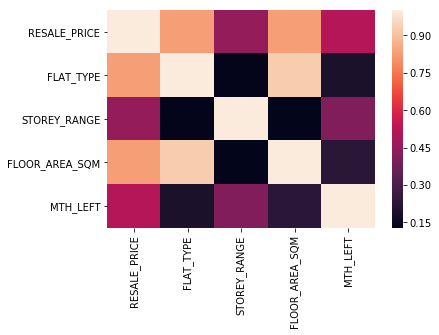

In [30]:
# A simple checkpoint and visualisation.
# What are some insights you see here?
# How much of the insights are due to the assumptions we made above?
import seaborn as sns

df5_test = df5.loc[df5["TOWN"] == "BISHAN", ["RESALE_PRICE", "FLAT_TYPE", "STOREY_RANGE", "FLOOR_AREA_SQM", "MTH_LEFT"]]

sns.heatmap(df5_test.corr())

While there are automatic algorithms to conduct feature selection, without knowing the mechanics of how it works, we may be confused as to why a particular feature was dropped over the other. You may wish to take a look at these 2 functions if you wish to know more:  

*from sklearn.feature_selection import SelectKBest, chi2*

For the purposes of this guide, we can assume that we'd want all x variables to be fed into the model. As above, we can also fuse other datasets together to get more feature variables, but that beyond the scope of this guide. Let's proceed into the actual model.

#### <a id = "VOL4_modelprep"> Model Prep, Dataset split </a>  

[Return to top](#VOL4_toc)  

Looking at our dataset, while it is largely fit for usage, we still have the "TOWN" column that needs to be processed. We know that label encoding *should* be out of the question (hard to argue that little india is a 'better' place than bishan or vice versa). Hence that leaves us with 2 other options:  

- __To group each town into regions (Rest of Central Region), (Core Central Region), (Outside Central Region)__  

To do this, we would simply need to find the towns that correspond to each region (probably available in most property websites like property guru. This can be seen as a loss of information (as we are grouping bedok, punggol, woodlands and tengah together). One can argue that a 4 room located close to the MRT in these 4 towns will be priced differently (all else being held equal). Once the towns are grouped together, we can convert it to ordered labels 3 > 2 > 1.  

After checking the internet, I think regions are slightly inappropriate as there's no clear cut 1-1 mapping in terms of districts to such regions. For example, PropertyGuru uses some parts of district X to group with CCR and OCR.

- __To create a new column for each town. This will create 20+ new columns for a dataset with 110k rows.__  

Given that the towns are not really comparable, we should ideally apply one-hot encoding for this column. This will represent each town in a separate column such that it's easier for the model to read and perform machine learning. That said, you would have to consider the size constraints. 25 columns on 110k rows (albeit just 1s and 0s) is about 2.5m + additional cells. This resource trade off is just something we should keep in mind.  

For this project, we'll just create a new column for each town.

In [ ]:
# Should already be imported from above
# from sklearn import preprocessing

In [31]:
onehot = preprocessing.OneHotEncoder()
test = pd.DataFrame(onehot.fit_transform(df5[["TOWN"]]).toarray(), columns = df5["TOWN"].unique())

In [32]:
# You may wish to output this dataset into excel to check and verify the town column has been coded correctly.
df_final = pd.concat([df5, test], axis = "columns").drop(columns = "TOWN")

In [33]:
# As you can see, very large dataset
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114623 entries, 0 to 114622
Data columns (total 31 columns):
FLAT_TYPE          114623 non-null int64
STOREY_RANGE       114623 non-null int64
FLOOR_AREA_SQM     114623 non-null float64
RESALE_PRICE       114623 non-null float64
MTH_LEFT           114623 non-null int64
ANG MO KIO         114623 non-null float64
BEDOK              114623 non-null float64
BISHAN             114623 non-null float64
BUKIT BATOK        114623 non-null float64
BUKIT MERAH        114623 non-null float64
BUKIT PANJANG      114623 non-null float64
BUKIT TIMAH        114623 non-null float64
CENTRAL AREA       114623 non-null float64
CHOA CHU KANG      114623 non-null float64
CLEMENTI           114623 non-null float64
GEYLANG            114623 non-null float64
HOUGANG            114623 non-null float64
JURONG EAST        114623 non-null float64
JURONG WEST        114623 non-null float64
KALLANG/WHAMPOA    114623 non-null float64
MARINE PARADE      114623 non-null 

In [34]:
# ML models use arrays rather than dataframe.
# We use numpy's array, which is convertible from Pandas' dataframes.

X, y = np.array(df_final.drop(columns = "RESALE_PRICE")), np.array(df_final["RESALE_PRICE"])

In [35]:
# Convert all numbers to the range of 0 and 1.
# This is not strictly required for regression models, but applicable to other ML models where
# a gradient descent algorithm (neural network) is used. 0-1 values reduce computation expense.
# We can nontheless scale the feature variables, but for interpretation we need to rescale back to the original parameters.

minmax = preprocessing.MinMaxScaler()
X = minmax.fit_transform(X)

X[0:2]

array([[0.16666667, 0.1875    , 0.05963303, 0.62745098, 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.33333333, 0.        , 0.16513761, 0.61977835, 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

#### <a id = "VOL4_sampling"> Sampling </a>  

[Return to top](#VOL4_toc)

After the dataset has been processed, we need to break it up to train and test sets. Training sets trains and builds the model to adapt to the data in train set. The test set is used to validate or test the model's performance based on data it has not seen (i.e. real-life).  

There is a small nuance to sampling which depends on your Y labels (more applicable for classification problems). For example, given a dataset with predictor/target variable Y of "Cancer" or "No Cancer", given that cancer occurence happens in perhaps minority (surely not 50% of sample/population), performing train/test split may result in a trained model that only trains on mostly "No Cancer" data instead of a mix of both (so the model 'understands' how the other label looks like).  

This is where stratified sampling comes into play. Essentially it tries to maintain the distribution of class labels in Y for both your training and testing set. Let me provide an example.

In [36]:
from sklearn.model_selection import train_test_split

__random_state allows the split to be reproduced, which also makes the entire model evaluation reproducible.__

For example, running this function 3 times will result in different random datasets: abc, cab, ccc. Using random_state will ensure that the first 3 function calls for any other user using this script (including yourself if you restart the Jupyter Notebook/lab) will generate the same "random" datasets.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

# Use this for stratified sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
regression = LinearRegression()

training = regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

In [40]:
import matplotlib.pyplot as plt

(0.0, 1300000.0)


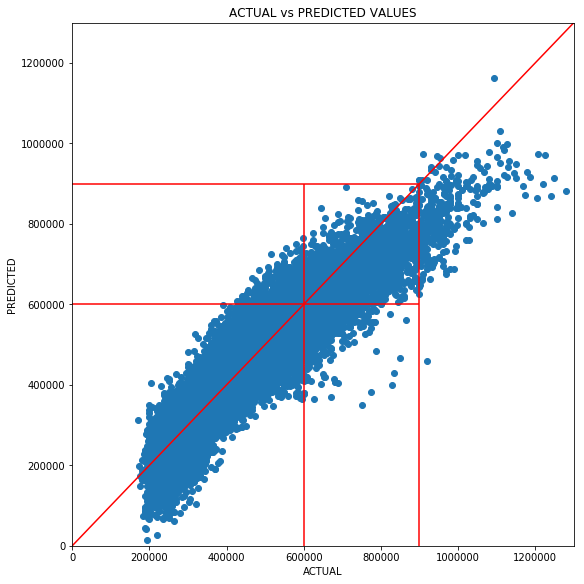

In [41]:
actual_fit = pd.DataFrame({"ACTUAL": y_test.flatten(), "PREDICTED": y_pred.flatten()})

lims = (0, 1300000)
fig, ax = plt.subplots(figsize = (8,8), constrained_layout = True)

ax.scatter(x = actual_fit["ACTUAL"], y = actual_fit["PREDICTED"])
ax.plot([0,1], [0, 1], transform = ax.transAxes, color = "r")

plt.vlines([600000, 900000], ymin = 0, ymax = 900000, colors = "red")
plt.hlines([600000, 900000], xmin = 0, xmax = 900000, colors = "red")
ax.set_ylim(lims)
ax.set_xlim(lims)

ax.set_xlabel("ACTUAL")
ax.set_ylabel("PREDICTED")
ax.set_title("ACTUAL vs PREDICTED VALUES")

print(ax.get_ylim())

A very simple visualisation to understand where the predict values match up against the test values. From the plot above, we can see a slight under-estimation of the resale price. For example, given a resale price of 600k and 900k, we can see the dispersion of actual values as well as what the model has predicted. For 600k, it seems to have a uniform error (skew towards lower estimations), whereas for 900k, it has a large downward skews.  

This means that it may not be able to predict high resale prices well (or even low prices). Or that the characteristics of the resale prices change as they get to higher prices. 

#### <a id = "VOL4_signif"> Significance </a>
[Return to top](#VOL4_toc)  

It's important to also test whether the feature variables (i.e. X variables) are statistically significant in predicicting resale prices. Correlation does not equal causation/prediction! For linear regression type models, can generally do that by testing for P values (as is the case in hypothesis testing) or calculating their F-statistics.  

Referenced from: https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/  

The p-values help determine whether the relationships that you observe in your sample also exist in the larger population. The p-value for each independent variable (X1, X2, ... , Xn) tests the null hypothesis (aka h0) that the variable has no correlation with the dependent variable. If no correlation, there is no association between changes in the X var and shifts in Y. If the p-value is less than your significance level (usually 0.05 / 5% or 0.01 / 1%), your sample data provides enough evidence to reject h0 for entire population (i.e. proof of non-zero correlation).  

Referenced from: https://statisticsbyjim.com/regression/interpret-f-test-overall-significance-regression/  

The F-test of overall significance indicates whether your model provides a better fit to the data than a model containing no independent variables (X). The latter model can be thought of as an intercept-only model. h0 = model with no independent variables fits the data as well as your model (i.e. your X variables have no statistical significance in predicting Y). While it looks similar to p-value tests, F-tests sum the predictive power of all independent variables and determines that it is unlikely that *all* of the coefficient equal zero (no significance to Y). A significant F-score here does not mean that individually the X variables are all significant. That can be checked with p-value tests.  

Not done.
https://statisticsbyjim.com/regression/model-specification-variable-selection/  
https://statisticsbyjim.com/regression/check-residual-plots-regression-analysis/

In [42]:
import sklearn.metrics
import statsmodels.api as sm

In [43]:
# Using X and y that was already created above.
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                 1.828e+04
Date:                Mon, 07 Feb 2022   Prob (F-statistic):               0.00
Time:                        10:06:03   Log-Likelihood:            -1.4362e+06
No. Observations:              114623   AIC:                         2.872e+06
Df Residuals:                  114593   BIC:                         2.873e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.273e+05   1431.691   -158.791      0.0

In [ ]:
help(plt.scatter)

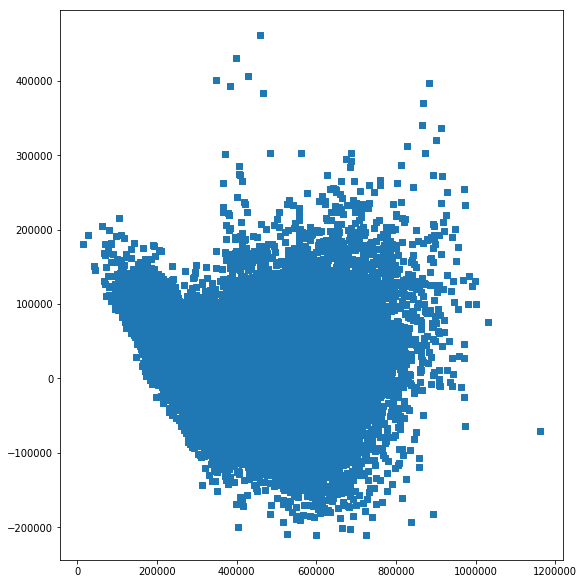

In [51]:
# Residual v fitted values.
actual_fit["RESIDUAL"] = actual_fit["ACTUAL"] - actual_fit["PREDICTED"]

fig, ax = plt.subplots(figsize = (8,8), constrained_layout = True)
ax.scatter(actual_fit["PREDICTED"], actual_fit["RESIDUAL"], marker = ",")
plt.show()

In [ ]:
# best subsets, stepwise regression - Not done